In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

## TEST GPU

In [4]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Get data path

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

## Get spectogram function from before

In [7]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
    
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

## Run the model with a specified waveform path

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 124, 129,   1], dtype=int32), 'shape_signature': array([ -1, 124, 129,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 17, 'shape': array([1, 8], dtype=int32), 'shape_signature': array([-1,  8], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[-5.3713846 -4.49941    2.9266112 -5.9102926 10.742723  -5.69839
  -3.506024  -6.1578827]]


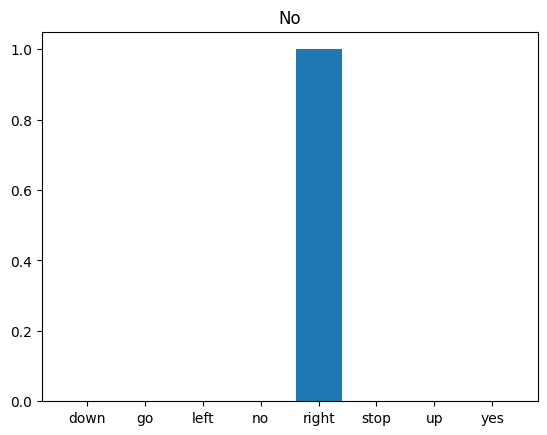

In [8]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter('model.tflite')
interpreter.allocate_tensors()

# my_signature = interpreter.get_signature_runner()
# print(my_signature)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Get waveform
# x = data_dir/'no/01bb6a2a_nohash_0.wav' #NO TEST
# x = data_dir/'right/012c8314_nohash_1.wav' #RIGHT TEST
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = x
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(output_data[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))